In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from lmfit.models import GaussianModel, LorentzianModel

In [71]:
%matplotlib notebook

In [3]:
titanium_S2sMo3dScan = pd.read_excel("XPS_Titanium.xlsx", sheet_name='S2sMo3dScanTi')

In [4]:
titanium_S2sMo3dScan.head()

,247.08,Unnamed: 1,0.12608,0.0655104,0.0542236
0,246.98,NaN,0.126774,0.026261,0.072778
1,246.88,NaN,0.026209,0.028436,0.095782
2,246.78,NaN,0.153251,0.068521,0.08844
3,246.68,NaN,0.144296,0.151661,0.078192
4,246.58,NaN,0.026768,0.086767,0.052717


In [5]:
def add_header_to_xlsx(file_path, sheet_name, new_header):
    """
    This function loads data from an Excel file, adds a custom header, and returns the updated DataFrame.
    
    :param file_path: Path to the Excel file
    :param sheet_name: The sheet name or sheet index to extract data from
    :param new_header: A list of column names to set as the header
    :return: DataFrame with the new header
    """
    # Load data from the Excel file without headers
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    
    # Add the new header to the DataFrame
    df.columns = new_header

    # Convert all columns to numeric, coercing non-numeric values to NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df

In [6]:
file_path = 'XPS_Titanium.xlsx'
sheet_name = 'S2sMo3dScanTi'  # Change this to the actual sheet name/index you're working with
new_header = ['Binding Energy', 'Empty', 'Intensity_1', 'Intensity_2', 'Intensity_3']  # Define your custom header

titanium_S2sMo3dScan = add_header_to_xlsx(file_path, sheet_name, new_header)

In [7]:
titanium_S2sMo3dScan.head()

,Binding Energy,Empty,Intensity_1,Intensity_2,Intensity_3
0,247.08,NaN,0.12608,0.06551,0.054224
1,246.98,NaN,0.126774,0.026261,0.072778
2,246.88,NaN,0.026209,0.028436,0.095782
3,246.78,NaN,0.153251,0.068521,0.08844
4,246.68,NaN,0.144296,0.151661,0.078192


In [8]:
binding_energy_S2sMo3d = titanium_S2sMo3dScan['Binding Energy']
intensity_1_S2sMo3d = titanium_S2sMo3dScan['Intensity_1']

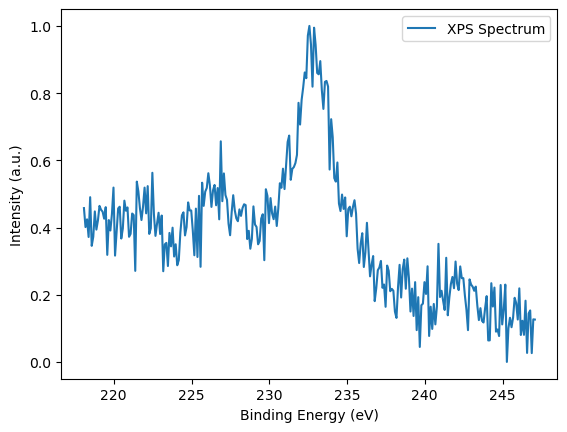

In [15]:
plt.plot(binding_energy_S2sMo3d, intensity_1_S2sMo3d, label='XPS Spectrum')
plt.xlabel('Binding Energy (eV)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.show()

In [17]:
# Gaussian function definition
def gaussian(x, amp, cen, width):
    return amp * np.exp(-(x - cen)**2 / (2 * width**2))

In [19]:
def clean_data_fitting(x_data, y_data):
    """
    This function removes NaNs and infinite values from two input arrays (x and y).
    It returns the cleaned versions of the arrays where both x and y are finite.

    :param x_data: Array-like, the x-axis data (e.g., binding energy)
    :param y_data: Array-like, the y-axis data (e.g., intensity)
    :return: Tuple of cleaned x_data and y_data
    """
    # Convert the input data to numpy arrays (in case they are not already)
    x_data = np.asarray(x_data, dtype=np.float64)
    y_data = np.asarray(y_data, dtype=np.float64)
    
    # Create a mask to filter out NaN or inf values from both arrays
    mask = np.isfinite(x_data) & np.isfinite(y_data)
    
    # Return the cleaned data
    return x_data[mask], y_data[mask]

In [20]:
# Clean the data using the function
binding_energy_clean, intensity_clean = clean_data_fitting(binding_energy_S2sMo3d, intensity_1_S2sMo3d)

In [21]:
def perform_gaussian_fit(x_data, y_data, gaussian_func):
    """
    This function performs a Gaussian curve fitting on the provided x and y data.
    
    :param x_data: Array-like, the x-axis data (e.g., binding energy)
    :param y_data: Array-like, the y-axis data (e.g., intensity)
    :param gaussian_func: The Gaussian function to fit
    :return: Tuple of optimal fitting parameters (popt) and the covariance of the parameters (pcov)
    """
    # Initial guess for the fitting parameters: [amplitude, center, width]
    initial_guess = [max(y_data), x_data[np.argmax(y_data)], 1.0]
    
    # Perform the curve fitting with the cleaned data
    popt, pcov = curve_fit(gaussian_func, x_data, y_data, p0=initial_guess)
    
    return popt, pcov

In [22]:
# Perform Gaussian fitting using the function
popt, pcov = perform_gaussian_fit(binding_energy_clean, intensity_clean, gaussian)

# Print the optimal parameters and covariance matrix
print("Optimal parameters:", popt)
print("Covariance of the parameters:", pcov)

Optimal parameters: [  0.5463985  228.86652913   9.41236952]
Covariance of the parameters: [[ 0.00018886  0.00066475 -0.00329002]
 [ 0.00066475  0.10341799 -0.0478921 ]
 [-0.00329002 -0.0478921   0.15211837]]


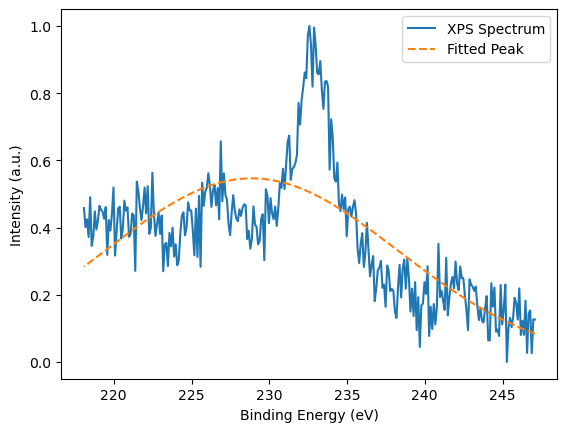

In [23]:
# Plot the fit
fit_intensity = gaussian(binding_energy_clean, *popt)
plt.plot(binding_energy_clean, intensity_clean, label='XPS Spectrum')
plt.plot(binding_energy_clean, fit_intensity, label='Fitted Peak', linestyle='--')
plt.xlabel('Binding Energy (eV)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.show()

In [25]:
def fit_xps_data_gaussian(binding_energy, intensity):
    """
    This function performs a Gaussian fit on the provided XPS data and plots the original data along with the Gaussian fit.
    
    :param binding_energy: Array-like, the x-axis data (e.g., binding energy)
    :param intensity: Array-like, the y-axis data (e.g., intensity)
    :return: Fitting result object from lmfit
    """
    # Create a Gaussian model
    gaussian_model = GaussianModel()
    
    # Set initial parameters: amplitude, center, and sigma (width)
    params = gaussian_model.make_params(amplitude=max(intensity), 
                                        center=binding_energy[np.argmax(intensity)], 
                                        sigma=1.0)
    
    # Perform the fit
    result = gaussian_model.fit(intensity, params, x=binding_energy)
    
    # Plot the original data and the fit
    plt.plot(binding_energy, intensity, label='XPS Spectrum')
    plt.plot(binding_energy, result.best_fit, label='Gaussian Fit', linestyle='--')
    plt.xlabel('Binding Energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend()
    plt.show()
    
    # Print the fitting report
    print(result.fit_report())
    
    return result

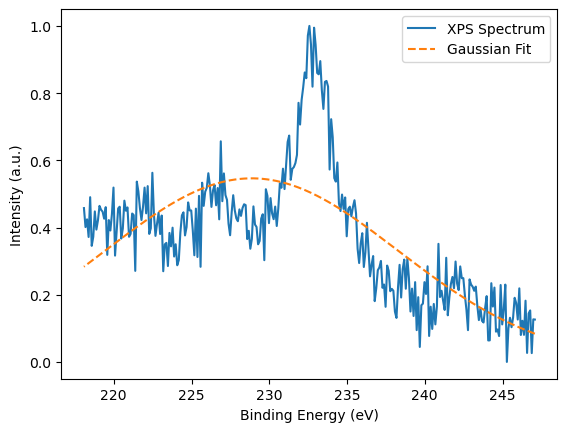

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 291
    # variables        = 3
    chi-square         = 5.27457942
    reduced chi-square = 0.01831451
    Akaike info crit   = -1161.03348
    Bayesian info crit = -1150.01351
    R-squared          = 0.52496011
[[Variables]]
    amplitude:  12.8914169 +/- 0.42177416 (3.27%) (init = 1)
    center:     228.866469 +/- 0.32161527 (0.14%) (init = 232.58)
    sigma:      9.41244321 +/- 0.39008239 (4.14%) (init = 1)
    fwhm:       22.1646095 +/- 0.91857382 (4.14%) == '2.3548200*sigma'
    height:     0.54639708 +/- 0.01374255 (2.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.7948
    C(center, sigma)     = -0.3820
    C(amplitude, center) = -0.3681
Parameters([('amplitude', <Parameter 'amplitude', value=12.8914169394949 +/- 0.422, bounds=[-inf:inf]>), ('center', <Parameter

In [26]:
# Assuming `binding_energy` and `intensity` are already part of your tuned DataFrame
fit_result = fit_xps_data_gaussian(binding_energy_clean, intensity_clean)

# Access the fitting parameters from the result
print(fit_result.params)

In [27]:
# Define a sum of Gaussians for multiple peak fitting
def multiple_gaussians(x, *params):
    """
    This function represents the sum of multiple Gaussian functions.
    
    :param x: Array-like, the x-axis data (e.g., binding energy)
    :param params: A flat list of parameters (amplitude, center, width) for each Gaussian
    :return: The sum of Gaussians evaluated at x
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, width = params[i:i+3]
        y += gaussian(x, amp, cen, width)
    return y

In [28]:
# Fitting function for multiple peaks
def fit_multiple_gaussians(binding_energy, intensity, initial_guess):
    """
    Perform fitting of multiple Gaussian peaks to the provided XPS data.
    
    :param binding_energy: Array-like, the x-axis data (e.g., binding energy)
    :param intensity: Array-like, the y-axis data (e.g., intensity)
    :param initial_guess: A list of initial guess parameters for the peaks (amp1, cen1, width1, amp2, cen2, width2, ...)
    :return: Optimal parameters for the fit (popt) and the covariance of the parameters (pcov)
    """
    # Perform the fit using curve_fit
    popt, pcov = curve_fit(multiple_gaussians, binding_energy, intensity, p0=initial_guess)
    
    # Plot the original data and the fit
    plt.plot(binding_energy, intensity, label='XPS Spectrum')
    plt.plot(binding_energy, multiple_gaussians(binding_energy, *popt), label='Multiple Gaussian Fit', linestyle='--')
    plt.xlabel('Binding Energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend()
    plt.show()
    
    return popt, pcov

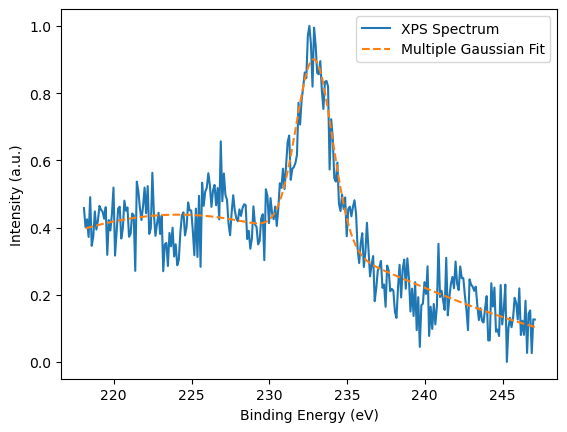

Optimal parameters: [  0.54507992 232.89694161   1.1641494    0.43826702 224.15721028
  13.51586988]


In [29]:
# Initial guesses for two peaks (amp1, cen1, width1, amp2, cen2, width2)
initial_guess = [
    max(intensity_clean), binding_energy_clean[np.argmax(intensity_clean)], 1.0,  # First peak
    0.5 * max(intensity_clean), binding_energy_clean[np.argmax(intensity_clean)] - 2, 1.0  # Second peak
]

# Perform the fit
popt, pcov = fit_multiple_gaussians(binding_energy_clean, intensity_clean, initial_guess)

# Print the optimal fitting parameters
print("Optimal parameters:", popt)

In [33]:
def fit_multiple_gaussians(binding_energy, intensity, initial_guess):
    """
    Perform fitting of multiple Gaussian peaks to the provided XPS data.
    
    :param binding_energy: Array-like, the x-axis data (e.g., binding energy)
    :param intensity: Array-like, the y-axis data (e.g., intensity)
    :param initial_guess: A list of initial guess parameters for the peaks (amp1, cen1, width1, ...)
    :return: Optimal parameters for the fit (popt) and the covariance of the parameters (pcov)
    """
    bounds = (0, [np.inf] * len(initial_guess))  # Only positive amplitudes
    popt, pcov = curve_fit(multiple_gaussians, binding_energy, intensity, p0=initial_guess, bounds=bounds, maxfev=100000)
    
    # Plot the original data and the fit
    plt.plot(binding_energy, intensity, label='XPS Spectrum')
    plt.plot(binding_energy, multiple_gaussians(binding_energy, *popt), label='Multiple Gaussian Fit', linestyle='--')
    plt.xlabel('Binding Energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    plt.legend()
    plt.show()
    
    return popt, pcov

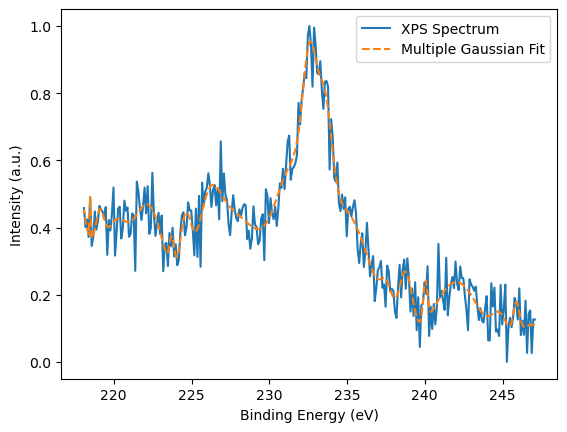

In [34]:
# Detect potential peak centers
peaks, _ = find_peaks(intensity_clean, height=0.1 * max(intensity_clean))  # Adjust height threshold

# Create initial guess based on detected peaks
initial_guess = []
for peak in peaks:
    amp_guess = intensity_clean[peak]
    cen_guess = binding_energy_clean[peak]
    width_guess = 1.0  # You can tweak the width as per your data
    initial_guess.extend([amp_guess, cen_guess, width_guess])

# Perform the fit using the generated initial guess
popt, pcov = fit_multiple_gaussians(binding_energy_clean, intensity_clean, initial_guess)

In [61]:
def fit_multiple_gaussians(binding_energy, intensity, num_peaks):
    """
    Perform fitting of multiple Gaussian peaks to the provided XPS data.
    
    :param binding_energy: Array-like, the x-axis data (e.g., binding energy)
    :param intensity: Array-like, the y-axis data (e.g., intensity)
    :param num_peaks: Number of peaks to detect and fit
    :return: Optimal parameters for the fit (popt) and the covariance of the parameters (pcov)
    """
    # Detect potential peak centers
    peaks, _ = find_peaks(intensity, height=0.1 * max(intensity))  # Adjust height threshold
    
    # Limit the number of peaks to the user-defined value
    if len(peaks) > num_peaks:
        peaks = peaks[:num_peaks]

    # Create initial guess based on detected peaks
    initial_guess = []
    for peak in peaks:
        amp_guess = intensity[peak]
        cen_guess = binding_energy[peak]
        width_guess = 1.0  # Adjust as necessary
        initial_guess.extend([amp_guess, cen_guess, width_guess])

    # Ensure we have enough parameters for the fit
    if len(initial_guess) == 0:
        print("No peaks detected. Unable to fit.")
        return None, None
    
    bounds = (0, [np.inf] * len(initial_guess))  # Only positive amplitudes
    popt, pcov = curve_fit(multiple_gaussians, binding_energy, intensity, p0=initial_guess, bounds=bounds, maxfev=100000)
    
    # Plot the original data and the fit
    plt.figure(figsize=(10, 6))
    plt.plot(binding_energy, intensity, label='XPS Spectrum', color='black')
    plt.plot(binding_energy, multiple_gaussians(binding_energy, *popt), label='Total Fit', linestyle='--', color='red')

    # Plot each individual Gaussian component
    for i in range(0, len(popt), 3):
        individual_gaussian = gaussian(binding_energy, popt[i], popt[i + 1], popt[i + 2])
        plt.plot(binding_energy, individual_gaussian, linestyle=':', label=f'Gaussian {i // 3 + 1}')
    
    plt.xlabel('Binding Energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    plt.title('Multiple Gaussian Fit')
    plt.legend()
    plt.show()
    
    return popt, pcov

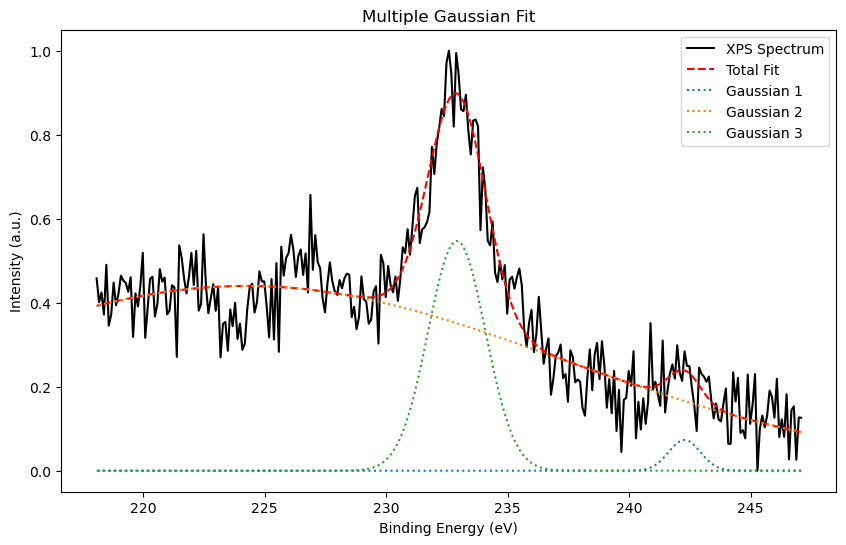

Optimal parameters: [7.32905547e-02 2.42277887e+02 6.52264905e-01 4.39977156e-01
 2.24246069e+02 1.29066101e+01 5.47155870e-01 2.32906232e+02
 1.18044396e+00]


In [62]:
num_peaks = 3  # User-defined number of peaks to detect

# Perform the fit
popt, pcov = fit_multiple_gaussians(binding_energy_clean, intensity_clean, num_peaks)

# Print the optimal fitting parameters
if popt is not None:
    print("Optimal parameters:", popt)

In [68]:
class PeakFitter:
    def __init__(self, binding_energy, intensity):
        self.binding_energy = binding_energy
        self.intensity = intensity
        self.selected_peaks = []
        
        # Set up the initial plot
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        plt.subplots_adjust(bottom=0.2)
        self.ax.plot(binding_energy, intensity, label='XPS Spectrum', color='black')
        self.ax.set_xlabel('Binding Energy (eV)')
        self.ax.set_ylabel('Intensity (a.u.)')
        self.ax.set_title('Select Peaks to Fit')
        self.ax.legend()
        
        # Create a button to perform fitting
        self.fit_button_ax = plt.axes([0.81, 0.05, 0.1, 0.075])
        self.fit_button = Button(self.fit_button_ax, 'Fit Peaks')
        self.fit_button.on_clicked(self.fit_peaks)

        # Connect the click event
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)

    def onclick(self, event):
        if event.inaxes == self.ax and event.button == 1:  # Left mouse button
            # Append the clicked position to the selected peaks
            self.selected_peaks.append(event.xdata)
            print(f'Selected peak at: {event.xdata:.2f} eV')
            self.update_plot()

    def update_plot(self):
        # Clear previous fits
        self.ax.lines = self.ax.lines[:1]  # Keep only the original spectrum line
        self.ax.plot(self.binding_energy, self.intensity, label='XPS Spectrum', color='black')
        
        # Plot selected peaks
        for peak in self.selected_peaks:
            self.ax.axvline(x=peak, linestyle='--', color='red', label=f'Selected Peak: {peak:.2f} eV')
        
        self.ax.legend()
        plt.draw()

    def fit_peaks(self, event):
        # Create initial guesses based on selected peaks
        initial_guess = []
        for peak in self.selected_peaks:
            amp_guess = max(self.intensity)  # Example guess for amplitude
            cen_guess = peak
            width_guess = 1.0  # Example guess for width
            initial_guess.extend([amp_guess, cen_guess, width_guess])

        # Perform the fit
        popt, _ = curve_fit(multiple_gaussians, self.binding_energy, self.intensity, p0=initial_guess)

        # Plot the total fit
        fit_line = multiple_gaussians(self.binding_energy, *popt)
        self.ax.plot(self.binding_energy, fit_line, linestyle='--', color='blue', label='Total Fit')

        # Plot individual Gaussian components
        for i in range(0, len(popt), 3):
            individual_gaussian = gaussian(self.binding_energy, popt[i], popt[i + 1], popt[i + 2])
            self.ax.plot(self.binding_energy, individual_gaussian, linestyle=':', label=f'Gaussian {i // 3 + 1}')

        # Show updated legend
        self.ax.legend()
        plt.draw()

In [72]:
# Initialize the peak fitter
peak_fitter = PeakFitter(binding_energy_clean, intensity_clean)
plt.show()

<IPython.core.display.Javascript object>